In [1]:
import sys

import socket
import traceback
import cv2
from imutils.video import VideoStream
import imagezmq
import threading
import numpy as np
from time import sleep
import simplejpeg


In [2]:
%run utils.ipynb

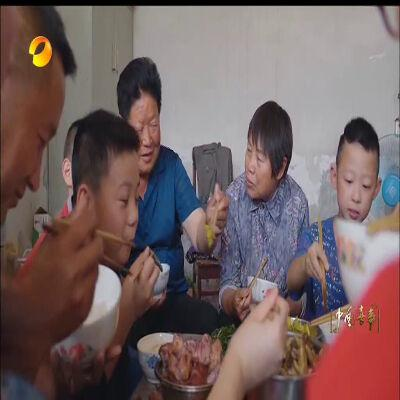

Exit due to keyboard interrupt


SystemExit: 

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
# Helper class implementing an IO deamon thread
class VideoStreamSubscriber:

    def __init__(self, hostname, port):
        self.hostname = hostname
        self.port = port
        self._stop = False
        self._data_ready = threading.Event()
        self._thread = threading.Thread(target=self._run, args=())
        self._thread.daemon = True
        self._thread.start()

    def receive(self, timeout=15.0):
        flag = self._data_ready.wait(timeout=timeout)
        if not flag:
            raise TimeoutError(
                "Timeout while reading from subscriber tcp://{}:{}".format(self.hostname, self.port))
        self._data_ready.clear()
        return self._data

    def _run(self):
        receiver = imagezmq.ImageHub("tcp://{}:{}".format(self.hostname, self.port), REQ_REP=False)
        while not self._stop:
            self._data = receiver.recv_jpg()
            self._data_ready.set()
        receiver.close()

    def close(self):
        self._stop = True

# Simulating heavy processing load
def limit_to_2_fps():
    sleep(0.5)

if __name__ == "__main__":
    # Receive from broadcast
    # There are 2 hostname styles; comment out the one you don't need
    hostname = "127.0.0.1"  # Use to receive from localhost
    # hostname = "192.168.86.38"  # Use to receive from other computer
    port = 5556
    receiver = VideoStreamSubscriber(hostname, port)

    try:
        while True:
            msg, jpg_buffer = receiver.receive()
#             image = cv2.imdecode(np.frombuffer(jpg_buffer, dtype='uint8'), -1)
            image = simplejpeg.decode_jpeg(jpg_buffer, colorspace='BGR', fastdct=False, fastupsample=False)

            # Due to the IO thread constantly fetching images, we can do any amount
            # of processing here and the next call to receive() will still give us
            # the most recent frame (more or less realtime behaviour)

            # Uncomment this statement to simulate processing load
            # limit_to_2_fps()   # Comment this statement out to run full speeed
            show_frame(image)
#             cv2.imshow("Pub Sub Receive", image)
#             cv2.waitKey(1)
    except (KeyboardInterrupt, SystemExit):
        print('Exit due to keyboard interrupt')
    except Exception as ex:
        print('Python error with no Exception handler:')
        print('Traceback error:', ex)
        traceback.print_exc()
    finally:
        receiver.close()
        sys.exit()